<a href="https://colab.research.google.com/github/lumagallacio/mask_detector/blob/master/create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## importações de bibliotecas

In [ ]:
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers


### Carregando uma imagem

In [ ]:
def select_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    image = image.resize((160,160))
    # convert to array
    return np.asarray(image)

### Carregando uma classe

In [ ]:
def load_classes(diretorio, classe, imagens, labels):
    # iterando arquivos

    for filename in listdir(diretorio):

        path = diretorio + filename

        try:
            imagens.append(select_image(path))
            labels.append(classe)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels

### Selecionando Dataset

In [ ]:
def select_data_set(diretorio):

    imagens = list()
    labels = list()

    for subdir in listdir(diretorio):
        # path
        path = diretorio + '/'+ subdir + '/'

        if not isdir(path):
            continue
        imagens, labels = load_classes(path, subdir, imagens, labels)

    return imagens, labels

### Carregando dataset Face

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Mask detection')
!pwd

/content/drive/My Drive/Colab Notebooks/Mask detection


In [ ]:

dataset = os.getcwd()+'/faces'
imagens, labels  = select_data_set(dataset)
imagens = np.array(imagens) / 255.0  ## convertendo de lista para array
labels = np.array(labels)  ## convertendo de lista para array

Erro ao ler imagem /content/drive/My Drive/Colab Notebooks/Mask detection/faces/maskon/mask (151).jpg


### Tratando classes - Labels

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Definindo hyperparametros

In [ ]:
batch_size   = 32
input_shape  = (160, 160, 3)
random_state = 42
alpha        = 1e-5
epoch        = 30

## CALLBACKS

Callback são classes que auxiliam o treinamento do modelo usando o Keras. As classes que usaremos são:

- ModelCheckpoint
- ReduceLROnPlateau
- EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#### ModelCheckpoint

ModelCheckpoint nos ajudará a salvar o modelo para cada época, para que possamos treinar nosso modelo e não nos preocuparmos com possíveis problemas que possam acontecer, como travamento da máquina.

- **filepath**: onde será salvo o modelo
- **monitor**: métrica a ser monitorada
- **verbose**: (1) mostra na barra de progresso (0) não
- **save_best_only**: Salvar somente o melhor modelo
- **mode**: como vamos monitorar o 'val_acc' o valor aqui vai ser 'max'. Queremos a máxima acurácia.


In [ ]:
filepath="detector.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#### ReduceLROnPlateau

Nos auxiliara a reduzir a taxa de aprendizado pelo fator (factor) caso não ocorra a mudança no loss.

- **monitor**: métrica a ser monitorada
- **factor**: fator de redução caso estejamos em um plator
- **min_delta**: valor mínimo da perda
- **patience**: só altere pelo fator após se repetir por 'patience' vezes.
- **verbose**: (1) mostra na barra de progresso (0) não


In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

### Array de Callbacks

In [ ]:
callbacks = [checkpoint, lr_reduce]

### Particionando dataset em teste e treino

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.20, stratify=labels, random_state=random_state)

## DATA AUGMENTATION

In [ ]:
train_datagen = ImageDataGenerator(
        horizontal_flip= True,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
        )

train_datagen.fit(trainX)

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

## TRANSFER LEARNING

In [ ]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

### Retreinando parte da VGG19



In [ ]:
conv_base.trainable = True
set_trainable = False

"""
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
"""

"\nfor layer in conv_base.layers:\n  if layer.name == 'block5_conv1':\n    set_trainable = True\n  if set_trainable:\n    layer.trainable = True\n  else:\n    layer.trainable = False\n"

In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## CRIANDO O MODELO COM A VGG19 COMO BASE

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6

## COMPILANDO O MODELO

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

## TREINANDO O MODELO

***Obs: não treinar na hora da live***

In [ ]:
history = model.fit_generator(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size, # parte inteira da divisão
                              validation_data=(testX, testY),
                              validation_steps=len(testX) // batch_size,# parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
47/47 [==============================] - ETA: 0s - loss: 0.3804 - acc: 0.8507
Epoch 00001: val_acc improved from -inf to 0.50000, saving model to detector.h5
47/47 [==============================] - 19s 397ms/step - loss: 0.3804 - acc: 0.8507 - val_loss: 7.6685 - val_acc: 0.5000 - lr: 0.0010
Epoch 2/30
47/47 [==============================] - ETA: 0s - loss: 0.2750 - acc: 0.8920
Epoch 00002: val_acc did not improve from 0.50000
47/47 [==============================] - 14s 296ms/step - loss: 0.2750 - acc: 0.8920 - val_loss: 7.6685 - val_acc: 0.5000 - lr: 0.0010
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 0.2744 - acc: 0.8867
Epoch 00003: val_acc did not improve from 0.50000
47/47 [==============================] - 14s 289ms/step - loss: 0.2744 - acc: 0.8867 - val_loss: 7.6685 - val_acc: 0.5000 - lr: 0.0010
Epoch 4/30
47/47 [==============================] - ETA: 0s - loss: 0.23

# ANALISANDO DADOS

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

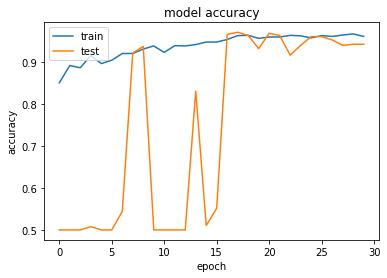

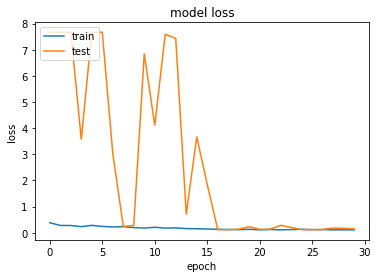

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Gerando matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

Acurácia: 0.9427
Sensitividade: 0.9010
Especificidade: 0.9844


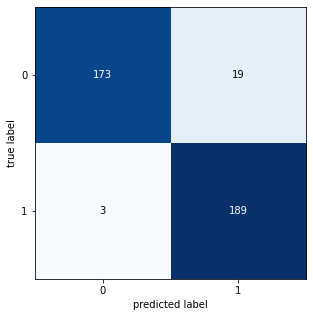

In [ ]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()